<a href="https://colab.research.google.com/github/ufbfung/data-science/blob/main/tcia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data
For the dataset, we will be using the Curated Breast Imaging Subset of Digital Database for Screening Mammography [CBIS-DDSM](https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=22516629).

# Detailed description
|Modalities|# participants|# studies|# series|# images|image size(GB)|
|--|--|--|--|--|--|
|MG|1,566*|6,775|6,775|10,239|163.6|


*The image data for this collection is structured such that each participant has multiple patient IDs.  For example, pat_id 00038 has 10 separate patient IDs which provide information about the scans within the IDs (e.g. Calc-Test_P_00038_LEFT_CC, Calc-Test_P_00038_RIGHT_CC_1)  This makes it appear as though there are 6,671 participants according to the DICOM metadata, but there are only 1,566 actual participants in the cohort.*

# API Access
Will leverage the REST APIs (vs. NBIA) to access the image data from TCIA. This can be found in [TCIA Programmatic Interface REST API Guides](https://wiki.cancerimagingarchive.net/display/Public/TCIA+Programmatic+Interface+REST+API+Guides).

# Environment setup
Follow instructions in here to setup environment before using API: https://github.com/kirbyju/TCIA_Notebooks?tab=readme-ov-file#environment-setup

In [2]:
# Setup environment
import os, sys, re
import importlib.util
import importlib.metadata

# Define the function to do the checking and install any missing dependencies
def _get_version(pkg):
    try:
        return importlib.metadata.version(pkg)
    except:
        pass
    try:
        return sys.modules[pkg].__version__
    except:
        return ''

def _pkg_version_pre(values):
    version, pre = None, False
    if len(values) == 3:
        version, pre = values[1:]
    elif len(values) == 2:
        pre = (values[1] == "pre")
        version = values[1] if not pre else version
    pkg = values[0]

    return pkg, version, pre

def check_for_package(req):
    values = list(filter(None, re.split(r"\[.*\]|==|>=|--| ", req))) # Grab the package name, version, and pre-release status
    install_req = re.split(r" --pre", req)[0] # Grab the string we need for installation
    pkg, version, pre = _pkg_version_pre(values)
    if (importlib.util.find_spec(pkg.replace("-", "_")) is None
        or (version and _get_version(pkg) != version)):
        print(f"{install_req} not found, installing {pkg} now...")
        if pre:
            !{sys.executable} -m pip install --upgrade --pre -q "{install_req}"
        else:
            !{sys.executable} -m pip install --upgrade -q "{install_req}"
    print(f"{pkg} version {_get_version(pkg)} installed.")
    print("-----")

# List of notebook requirements
reqs = [
    "tcia-utils",
    "rt-utils",
    "torch",
    "pydicom --pre",
    "pydicom-seg --pre",
    "scikit-image",
    "numpy",
    "pandas",
    "itk==5.3.0",
    "vtk",
    "monai[nibabel,itk,tqdm]==1.0.1",
    "nibabel",
    "tqdm",
    "itkwidgets[all]==1.0a23",
    "imjoy-elfinder",
    "imjoy-jupyter-extension",
    "imjoy-jupyterlab-extension",
]

# Upgrade pip, just in case.
!{sys.executable} -m pip install --upgrade -q pip

for req in reqs:
    check_for_package(req)

# Special case specific to running in AWS StudioLab
if "studio-lab-user" in os.getcwd():
    # Make sure that the imjoy extension is installed in the Jupyter environment
    # and not just the kernel environment since they may not be the same
    !conda env update -n studiolab -f environment.yml
    !conda install --yes -q --prefix {sys.prefix} -c conda-forge opencv nodejs

# Make sure that the required extension(s) are loaded.
# %%javascript
# let needReload = (typeof window.loadImJoyRPC === "undefined");
#if (needReload) {
#    needReload = false;
#    location.reload();
#}


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.0 MB/s eta 0:00:00
tcia-utils version 2.0.1 installed.
-----
rt-utils version 1.2.7 installed.
-----
torch version 2.1.0+cu121 installed.
-----
pydicom version 2.4.4 installed.
-----
pydicom-seg version 0.4.1 installed.
-----
scikit-image not found, installing scikit-image now...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 56.3 MB/s eta 0:00:00
scikit-image version 0.22.0 installed.
-----
numpy version 1.23.5 installed.
-----
pandas version 1.5.3 installed.
-----
itk==5.3.0 not found, installing itk now...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.6/25.6 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━

# API Setup
Begin setup for doing simple queries

In [3]:
!pip install --upgrade -q tcia-utils
!pip install -q pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 781.3 kB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires kaleido, which is not installed.
jupyter-events 0.9.0 requires jsonschema[format-nongpl]>=4.18.0, but you have jsonschema 3.2.0 which is incompatible.
jupyterlab-server 2.25.2 requires jsonschema>=4.18.0, but you have jsonschema 3.2.0 which is incompatible.


In [4]:
# imports
import requests
import pandas as pd
from tcia_utils import nbia

In [28]:
# df_collections = nbia.getCollections(format = 'df')

df_collections.head(n=5)

,Collection
0,4D-Lung
1,ACRIN-6698
2,ACRIN-Contralateral-Breast-MR
3,ACRIN-FLT-Breast
4,ACRIN-NSCLC-FDG-PET


In [32]:
# Define the collection of interest
coi = 'CBIS-DDSM'

# Identify which modality was used within our collection of interest
modalities = nbia.getModality(collection = coi, format = 'df')

modalities.head()

,Modality
0,MG


In [35]:
patients = nbia.getPatient(collection = coi, format = 'df')

patients.head()

,PatientId,PatientName,Collection,Phantom,SpeciesCode,SpeciesDescription
0,Mass-Training_P_01009_RIGHT_CC_1,Mass-Training_P_01009_RIGHT_CC_1,CBIS-DDSM,NO,337915000,Homo sapiens
1,Mass-Training_P_00061_RIGHT_MLO_1,Mass-Training_P_00061_RIGHT_MLO_1,CBIS-DDSM,NO,337915000,Homo sapiens
2,Mass-Training_P_00617_RIGHT_MLO_1,Mass-Training_P_00617_RIGHT_MLO_1,CBIS-DDSM,NO,337915000,Homo sapiens
3,Mass-Training_P_00417_RIGHT_MLO_1,Mass-Training_P_00417_RIGHT_MLO_1,CBIS-DDSM,NO,337915000,Homo sapiens
4,Mass-Training_P_01635_LEFT_CC_1,Mass-Training_P_01635_LEFT_CC_1,CBIS-DDSM,NO,337915000,Homo sapiens


In [37]:
study_details = nbia.getStudy(collection=coi, format='df')

study_details.head()

,StudyInstanceUID,StudyDate,StudyID,PatientID,PatientName,Collection,SeriesCount
0,1.3.6.1.4.1.9590.100.1.2.229361142710768138411...,2016-07-21 00:00:00.0,DDSM,Mass-Training_P_01009_RIGHT_CC_1,Mass-Training_P_01009_RIGHT_CC_1,CBIS-DDSM,1
1,1.3.6.1.4.1.9590.100.1.2.195593486612988388325...,2016-07-21 00:00:00.0,DDSM,Mass-Training_P_00061_RIGHT_MLO_1,Mass-Training_P_00061_RIGHT_MLO_1,CBIS-DDSM,1
2,1.3.6.1.4.1.9590.100.1.2.257901172612530623323...,2016-07-21 00:00:00.0,DDSM,Mass-Training_P_00617_RIGHT_MLO_1,Mass-Training_P_00617_RIGHT_MLO_1,CBIS-DDSM,1
3,1.3.6.1.4.1.9590.100.1.2.109468616710242115222...,2016-07-21 00:00:00.0,DDSM,Mass-Training_P_00417_RIGHT_MLO_1,Mass-Training_P_00417_RIGHT_MLO_1,CBIS-DDSM,1
4,1.3.6.1.4.1.9590.100.1.2.380627129513562450304...,2016-07-21 00:00:00.0,DDSM,Mass-Training_P_01635_LEFT_CC_1,Mass-Training_P_01635_LEFT_CC_1,CBIS-DDSM,1


In [38]:
series = nbia.getSeries(collection=coi, format='df')

series.head()

,SeriesInstanceUID,StudyInstanceUID,Modality,SeriesDescription,BodyPartExamined,SeriesNumber,Collection,PatientID,ImageCount,TimeStamp,LicenseName,LicenseURI,CollectionURI,FileSize
0,1.3.6.1.4.1.9590.100.1.2.117041576511324414842...,1.3.6.1.4.1.9590.100.1.2.229361142710768138411...,MG,ROI mask images,BREAST,1,CBIS-DDSM,Mass-Training_P_01009_RIGHT_CC_1,2,2016-08-01 02:21:04.0,Creative Commons Attribution 3.0 Unported License,http://creativecommons.org/licenses/by/3.0/,https://doi.org/10.7937/K9/TCIA.2016.7O02S9CY,18444684
1,1.3.6.1.4.1.9590.100.1.2.438738396107617880132...,1.3.6.1.4.1.9590.100.1.2.195593486612988388325...,MG,ROI mask images,BREAST,1,CBIS-DDSM,Mass-Training_P_00061_RIGHT_MLO_1,2,2016-08-01 02:04:54.0,Creative Commons Attribution 3.0 Unported License,http://creativecommons.org/licenses/by/3.0/,https://doi.org/10.7937/K9/TCIA.2016.7O02S9CY,21983298
2,1.3.6.1.4.1.9590.100.1.2.767416741131676463382...,1.3.6.1.4.1.9590.100.1.2.257901172612530623323...,MG,ROI mask images,BREAST,1,CBIS-DDSM,Mass-Training_P_00617_RIGHT_MLO_1,2,2016-08-01 02:06:21.0,Creative Commons Attribution 3.0 Unported License,http://creativecommons.org/licenses/by/3.0/,https://doi.org/10.7937/K9/TCIA.2016.7O02S9CY,13334826
3,1.3.6.1.4.1.9590.100.1.2.296931352612305599800...,1.3.6.1.4.1.9590.100.1.2.109468616710242115222...,MG,ROI mask images,BREAST,1,CBIS-DDSM,Mass-Training_P_00417_RIGHT_MLO_1,2,2016-08-01 02:29:56.0,Creative Commons Attribution 3.0 Unported License,http://creativecommons.org/licenses/by/3.0/,https://doi.org/10.7937/K9/TCIA.2016.7O02S9CY,13105254
4,1.3.6.1.4.1.9590.100.1.2.436657670120353100077...,1.3.6.1.4.1.9590.100.1.2.380627129513562450304...,MG,ROI mask images,BREAST,1,CBIS-DDSM,Mass-Training_P_01635_LEFT_CC_1,2,2016-08-01 02:24:03.0,Creative Commons Attribution 3.0 Unported License,http://creativecommons.org/licenses/by/3.0/,https://doi.org/10.7937/K9/TCIA.2016.7O02S9CY,16029026


In [43]:
series = nbia.getSeries(collection=coi, format = 'json')

report = nbia.makeSeriesReport(series)

print(report)

None


In [48]:
# Get labels
mass_train_file_path = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQlBm9sRjAuS2hxGXTKZIv0pT2NHF4824ZSNjG3CNncR83dsxPHS8nNWlcKbc2cAEBCU0hynyyeqIBN/pub?gid=1244365857&single=true&output=csv'
mass_test_file_path = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQX6tUUEEg08ISUYeXcSeR65hjbkcrJkgq4InOsiLCbbB5logGjktydnRTkqByBiNQOvi0RFX90YH-y/pub?gid=1545649845&single=true&output=csv'
mass_train_csv = pd.read_csv(mass_train_file_path)
mass_train_csv = pd.read_csv(mass_test_file_path)

# Display labels
mass_train_csv.head()

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00016,4,LEFT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,Mass-Test_P_00016_LEFT_CC/1.3.6.1.4.1.9590.100...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...
1,P_00016,4,LEFT,MLO,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,Mass-Test_P_00016_LEFT_MLO/1.3.6.1.4.1.9590.10...,Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....,Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....
2,P_00017,2,LEFT,CC,1,mass,ROUND,CIRCUMSCRIBED,4,MALIGNANT,4,Mass-Test_P_00017_LEFT_CC/1.3.6.1.4.1.9590.100...,Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...
3,P_00017,2,LEFT,MLO,1,mass,ROUND,ILL_DEFINED,4,MALIGNANT,4,Mass-Test_P_00017_LEFT_MLO/1.3.6.1.4.1.9590.10...,Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....,Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....
4,P_00032,3,RIGHT,CC,1,mass,ROUND,OBSCURED,0,BENIGN,2,Mass-Test_P_00032_RIGHT_CC/1.3.6.1.4.1.9590.10...,Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....,Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....


<Axes: xlabel='numbers', ylabel='frequency'>

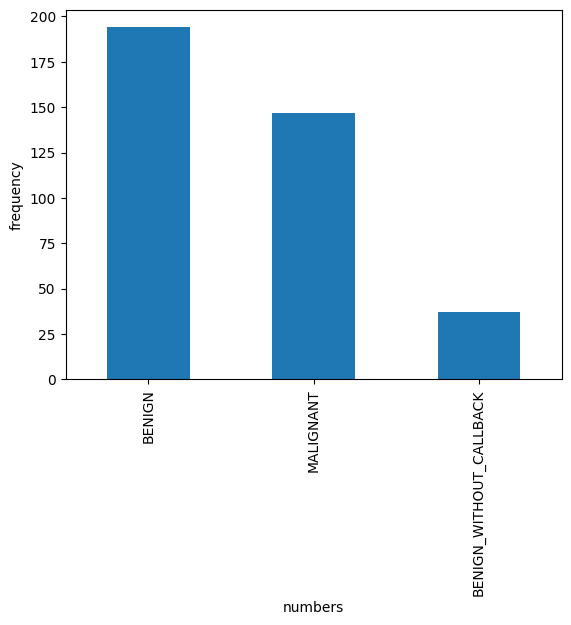

In [49]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
mass_train_csv['pathology'].value_counts().plot(ax=ax,
                                                kind='bar',
                                                xlabel='numbers',
                                                ylabel='frequency')